## Part 1 - data visualization

#### Preliminaries

First we import the libraries we will need, and the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spst, scipy.spatial as sp, scipy.cluster.hierarchy as hc
import seaborn as sns
from biokit.viz import corrplot, heatmap
import dcor
import copy

#### Data loading and inspection

The data (public) is from the paper **Many correlation coefficients, null hypoteses, and high value (Hunt, 2013, Reference 1)**; I used it previously in  my [Geoscience ML notebook 2](https://github.com/mycarta/predict/blob/master/Geoscience_ML_notebook_2.ipynb)
The dependent variable to be predicted, Y, is oil production (measured in tens of barrels of oil per day) from a marine barrier sand.
Independent variables are:

- Gross pay in meters

- Phi-h, with a 3% porosity cut-off

- Position in the reservoir. This is a ranked variable where a value close to 1 means the upper reservoir facies, a value close to 2 means the middle reservoir facies, and a value close to 3 means the lower reservoir facies.

- Pressure drawdown in MPa.

- 2 random variables

- 1 variable added by me (see my [Geoscience ML support notebook](https://github.com/mycarta/predict/blob/master/Geoscience_ML_support_for_notebook_2.ipynb)) as a log transform of Gross pay to simulate extremely highly correlated independent variables. 

In [2]:
data = pd.read_csv('../data/Table2_Hunt_2013_edit.csv')

In [3]:
data

,Gross pay,Phi-h,Position,Pressure,Random 1,Random 2,Gross pay transform,Production
0,0.1,0.5,2.1,19,5,379,3.54,15.10
1,1.0,4.0,1.1,16,13,269,5.79,21.30
2,1.9,19.0,1.0,14,12,245,8.51,22.75
3,3.1,21.7,2.1,17,6,273,11.52,15.72
4,4.1,24.6,2.9,11,10,237,10.16,7.71
5,4.9,39.2,1.1,12,7,278,11.14,22.67
6,5.9,23.6,2.1,13,13,241,15.04,18.11
7,7.0,63.0,2.0,13,20,269,15.10,24.30
8,8.1,72.9,2.9,14,1,248,14.49,24.04
9,8.9,35.6,2.8,16,1,210,16.90,25.11


We can print a list of the variables.

In [4]:
print (list(data))

['Gross pay', 'Phi-h', 'Position', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform', 'Production']


We can rearrange variable columns, then print a summary of the data and compare the row count to show there are no missing data points.

In [5]:
data = data.loc[:, ['Position', 'Gross pay', 'Phi-h', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform', 'Production']]
data.describe()

,Position,Gross pay,Phi-h,Pressure,Random 1,Random 2,Gross pay transform,Production
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,1.885714,9.823810,68.880952,15.285714,10.190476,292.714286,16.579524,33.428571
std,0.708721,5.948521,45.167894,2.759400,6.439092,59.429069,6.543793,15.141909
min,1.000000,0.100000,0.500000,10.000000,1.000000,210.000000,3.540000,7.710000
25%,1.100000,4.900000,24.600000,14.000000,6.000000,245.000000,11.520000,22.670000
50%,2.000000,10.000000,72.900000,16.000000,10.000000,273.000000,16.900000,36.420000
75%,2.200000,15.100000,100.000000,17.000000,13.000000,340.000000,21.970000,44.200000
max,2.900000,19.100000,160.000000,20.000000,21.000000,395.000000,29.250000,59.200000


We can also explicitly test to ensure data does not have no missing measurements.

In [6]:
data.isnull().values.any()

False

#### Visualization with a custom correlation matrix

https://blog.datadive.net/selecting-good-features-part-i-univariate-selection/

"While for Pearson correlation, the correlation value 0 does not imply independence (as we saw from the x vs x2 example), distance correlation of 0 does imply that there is no dependence between the two variables."

Distance correlation p-value like Thomas, using `dcor.independence.distance_covariance_test` see equivalence below:

https://dcor.readthedocs.io/en/latest/energycomparison.html

In [7]:
def dist_corr(X, Y, pval=True, nruns=2000):
    """ Distance correlation with p-value from bootstrapping
    """
    dc = dcor.distance_correlation(X, Y)
    pv = dcor.independence.distance_covariance_test(X, Y, exponent=1.0, num_resamples=nruns)[0]

    if pval:
        return (dc, pv)
    else:
        return dc

In [8]:
def corrfunc(x, y, **kws):
    d, p = dist_corr(x,y) 
    #print("{:.4f}".format(d), "{:.4f}".format(p))
    if p > 0.1:
        pclr = 'Darkgray'
    else:
        pclr= 'Darkblue'
    ax = plt.gca()
    #ax.annotate("p-value = {:.5f}".format(p), xy=(.1, 0.998), xycoords=ax.transAxes, color = pclr, fontsize = 14)
    ax.annotate("DC = {:.2f}".format(d), xy=(.1, 0.99), xycoords=ax.transAxes, color = pclr, fontsize = 14)

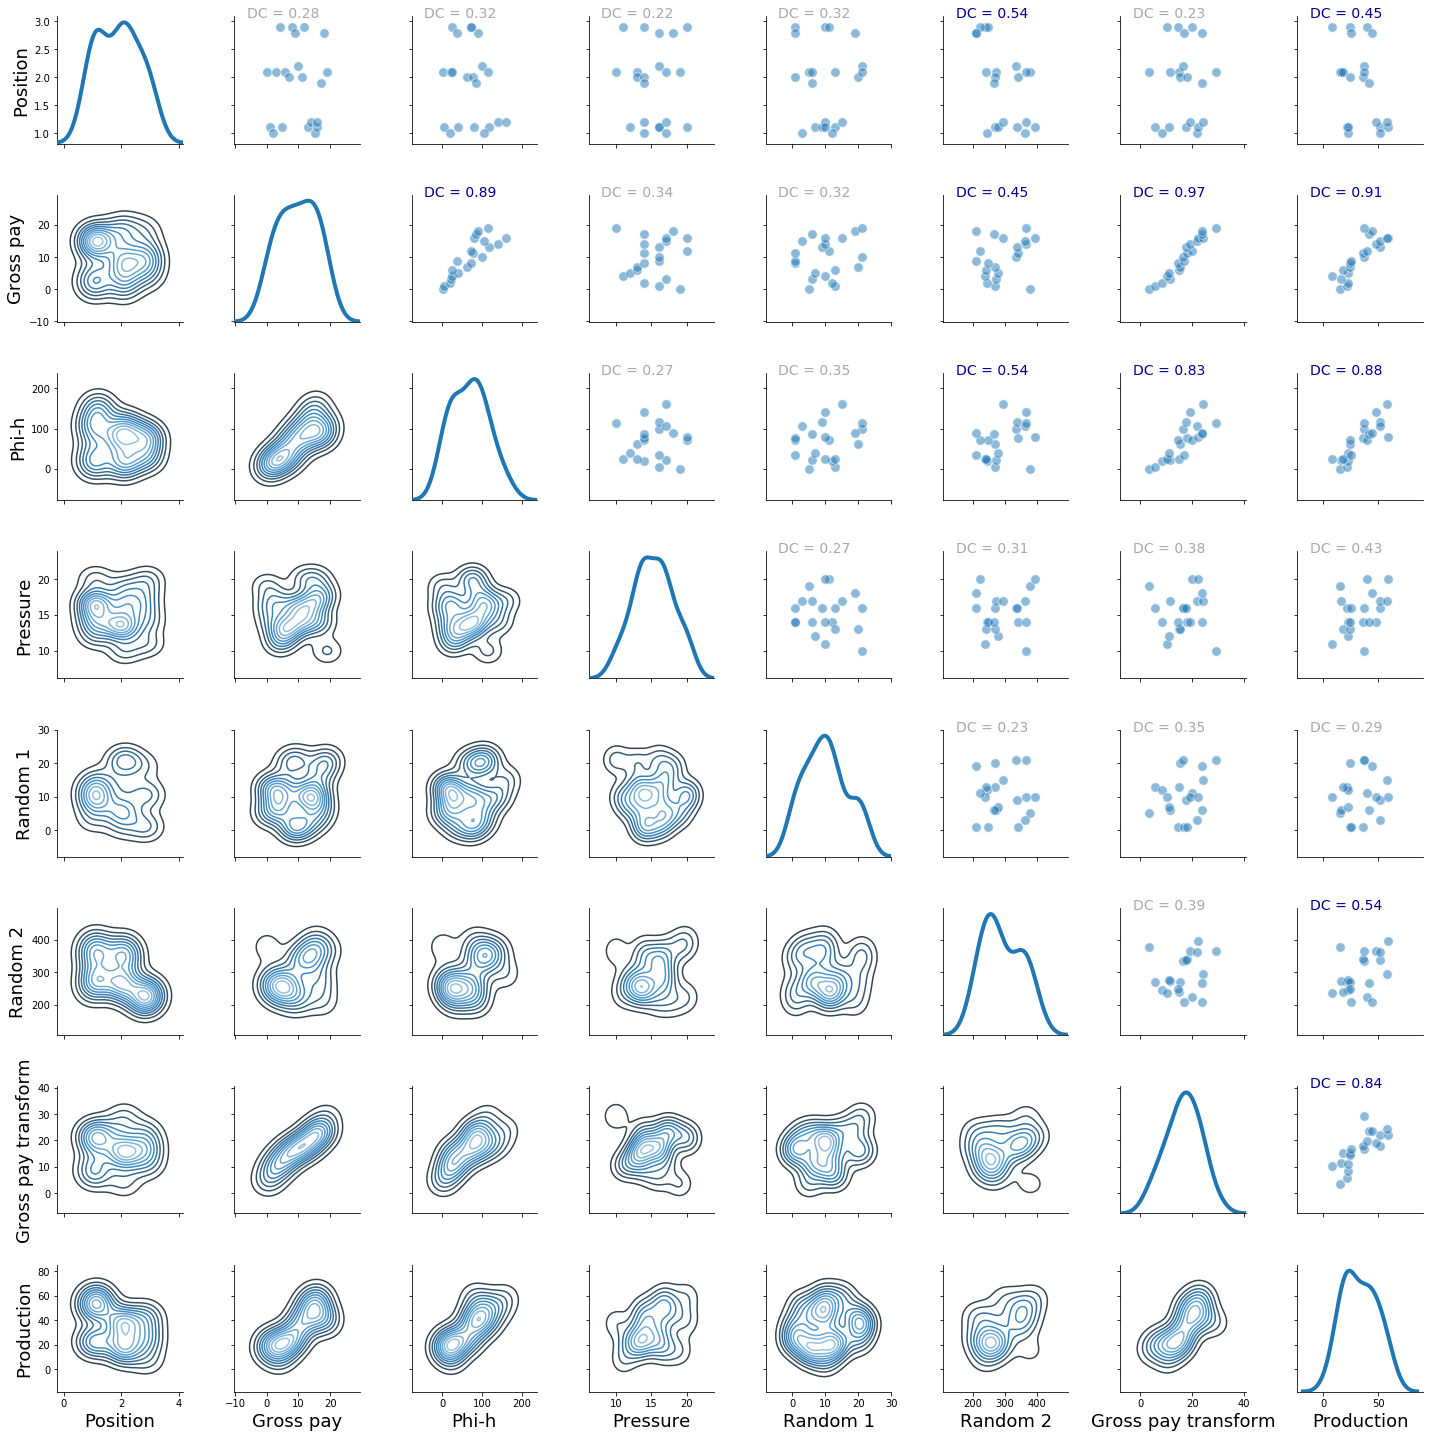

In [9]:
plt.rcParams["axes.labelsize"] = 18
g = sns.PairGrid(data, diag_sharey=False)
axes = g.axes

g.map_upper(plt.scatter,  linewidths=1, edgecolor="w", s=90, alpha = 0.5)
g.map_upper(corrfunc)

g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")

#plt.savefig('matrix_final.png', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

#### Clustering of independent variables only.

#### Using the [Biokit library](https://github.com/biokit/biokit/blob/master/notebooks/viz/corrplot.ipynb).

Baaed on:

- distance correlation

Displays bivariate ellipses in the lower triangle:
- ellipticity is proportional to the correlation coefficient
- direction and colour indicate whether positive or negative correlation

Notice that the correlation matrix is reordered by clustering correlated variables to facilitate interpretation. 
The more interestign ones are close to the diagonal.


Read more here:

- https://blogs.sas.com/content/iml/2018/05/02/reorder-variables-correlation-heat-map.html      
- https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html  
- https://github.com/biokit/biokit/blob/master/biokit/viz/corrplot.py


#### Distance correlation

Distance correlation from the [dcor library](https://github.com/vnmabus/dcor) and applied using a modification from [this SO answer on Euclidean distance](https://stackoverflow.com/a/29731899/1034648)

In [10]:
data=data.drop(columns=['Production'])

In [11]:
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2)
rslt = data.apply(lambda col1: data.apply(lambda col2: distcorr(col1, col2)))
pd.options.display.float_format = '{:,.2f}'.format
rslt

,Position,Gross pay,Phi-h,Pressure,Random 1,Random 2,Gross pay transform
Position,1.00,0.28,0.32,0.22,0.32,0.54,0.23
Gross pay,0.28,1.00,0.89,0.34,0.32,0.45,0.97
Phi-h,0.32,0.89,1.00,0.27,0.35,0.54,0.83
Pressure,0.22,0.34,0.27,1.00,0.27,0.31,0.38
Random 1,0.32,0.32,0.35,0.27,1.00,0.23,0.35
Random 2,0.54,0.45,0.54,0.31,0.23,1.00,0.39
Gross pay transform,0.23,0.97,0.83,0.38,0.35,0.39,1.00


In [12]:
c1 = corrplot.Corrplot(rslt)

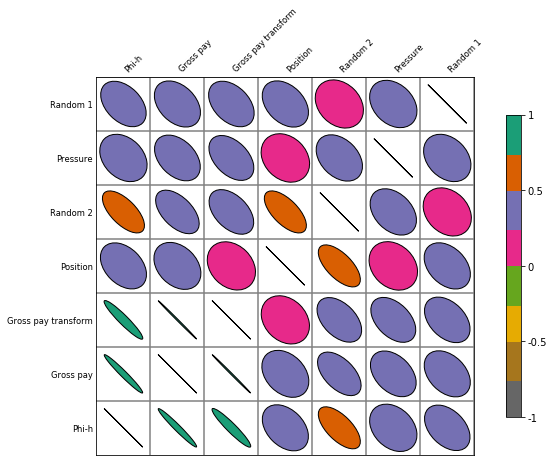

In [13]:
c1.plot(method='ellipse', cmap='Dark2_r', shrink=1, rotation=45)
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.gcf().get_axes()[0].invert_yaxis();
#plt.savefig('103_05-12_ellipses_cc_all_curv1.png', dpi=500, bbox_inches='tight', pad_inches=0.2)

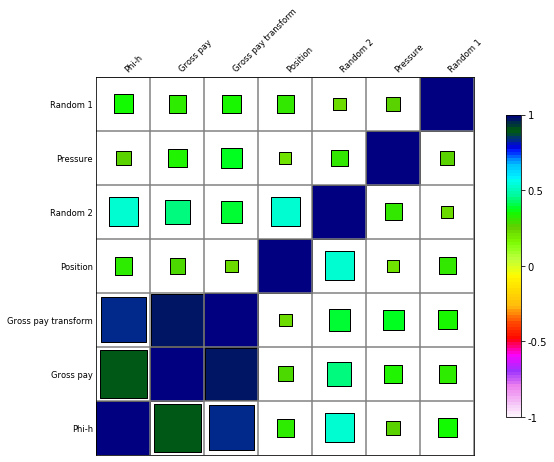

In [14]:
c1.plot(method='rectangle', cmap='gist_ncar_r', shrink=1, rotation=45)
fig = plt.gcf()
fig.set_size_inches(10, 8)
#plt.savefig('103_05-12_ellipses_cc_all_curv1.png', dpi=500, bbox_inches='tight', pad_inches=0.2)
plt.gcf().get_axes()[0].invert_yaxis();

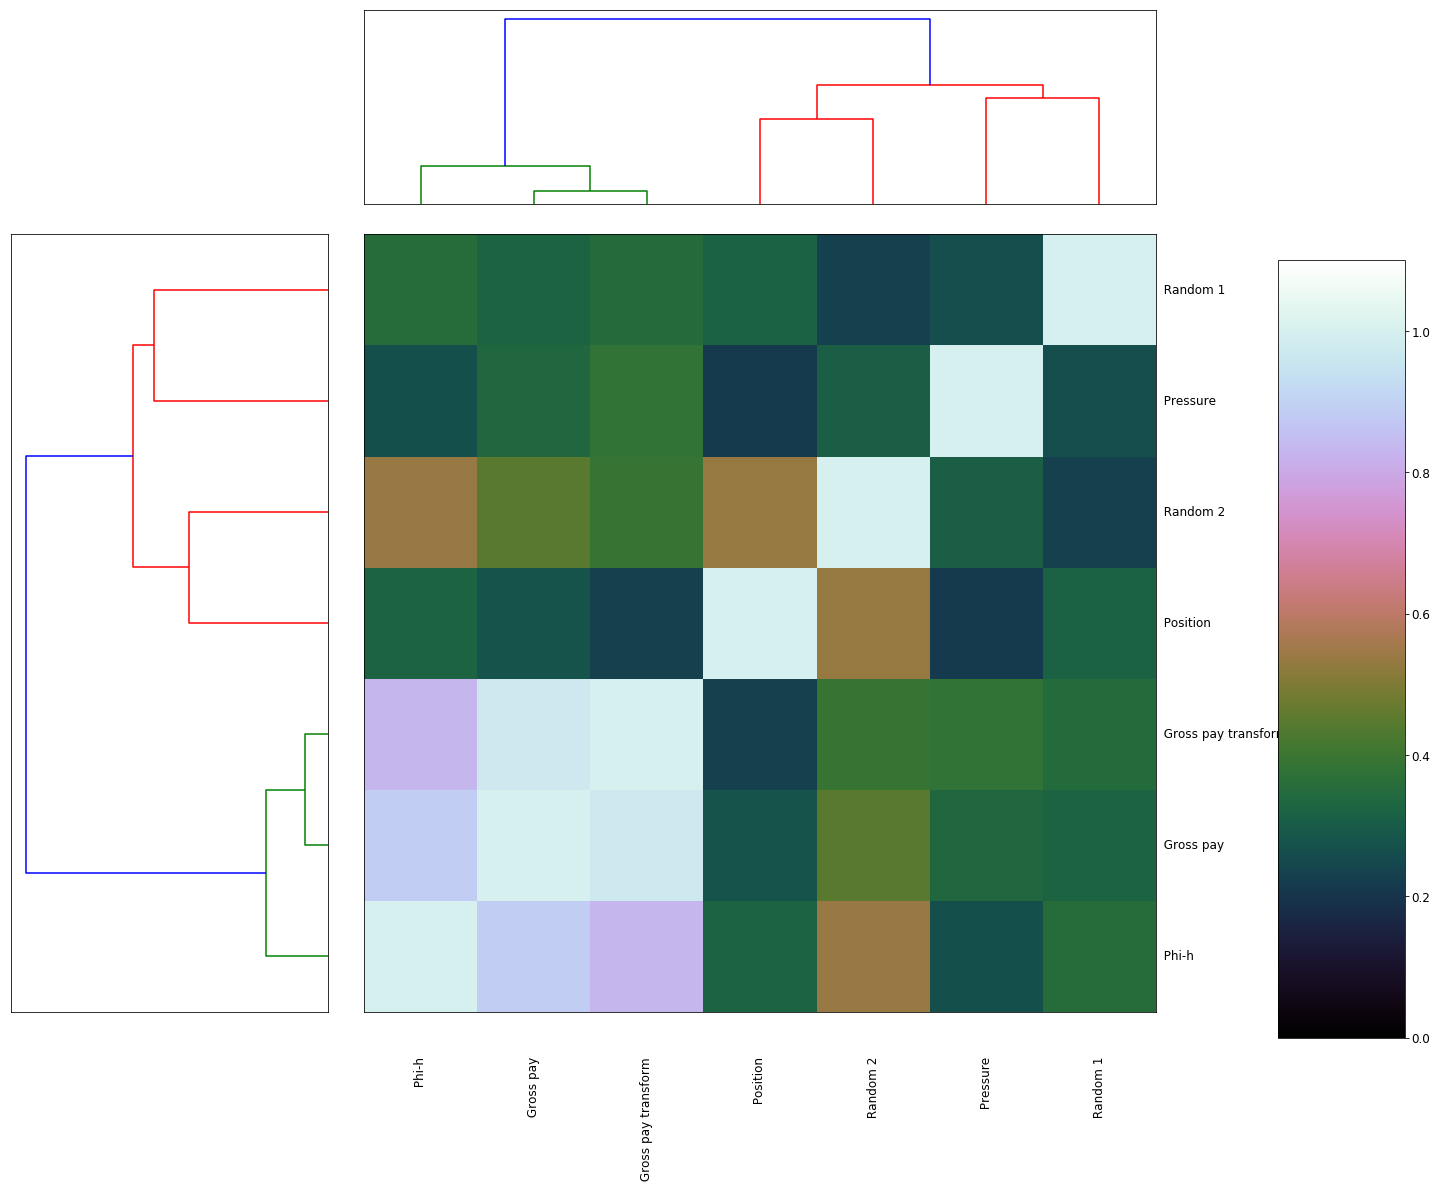

In [15]:
h = heatmap.Heatmap(rslt)
h.plot(vmin=0.0, vmax=1.1, cmap='cubehelix')
fig = plt.gcf()
fig.set_size_inches(22, 18)

plt.gcf().get_axes()[1].invert_xaxis();
#plt.gcf().get_axes()[1].invert_yaxis()
#plt.gcf().get_axes()[2].invert_yaxis()


#### SEABORN CLUSTERING

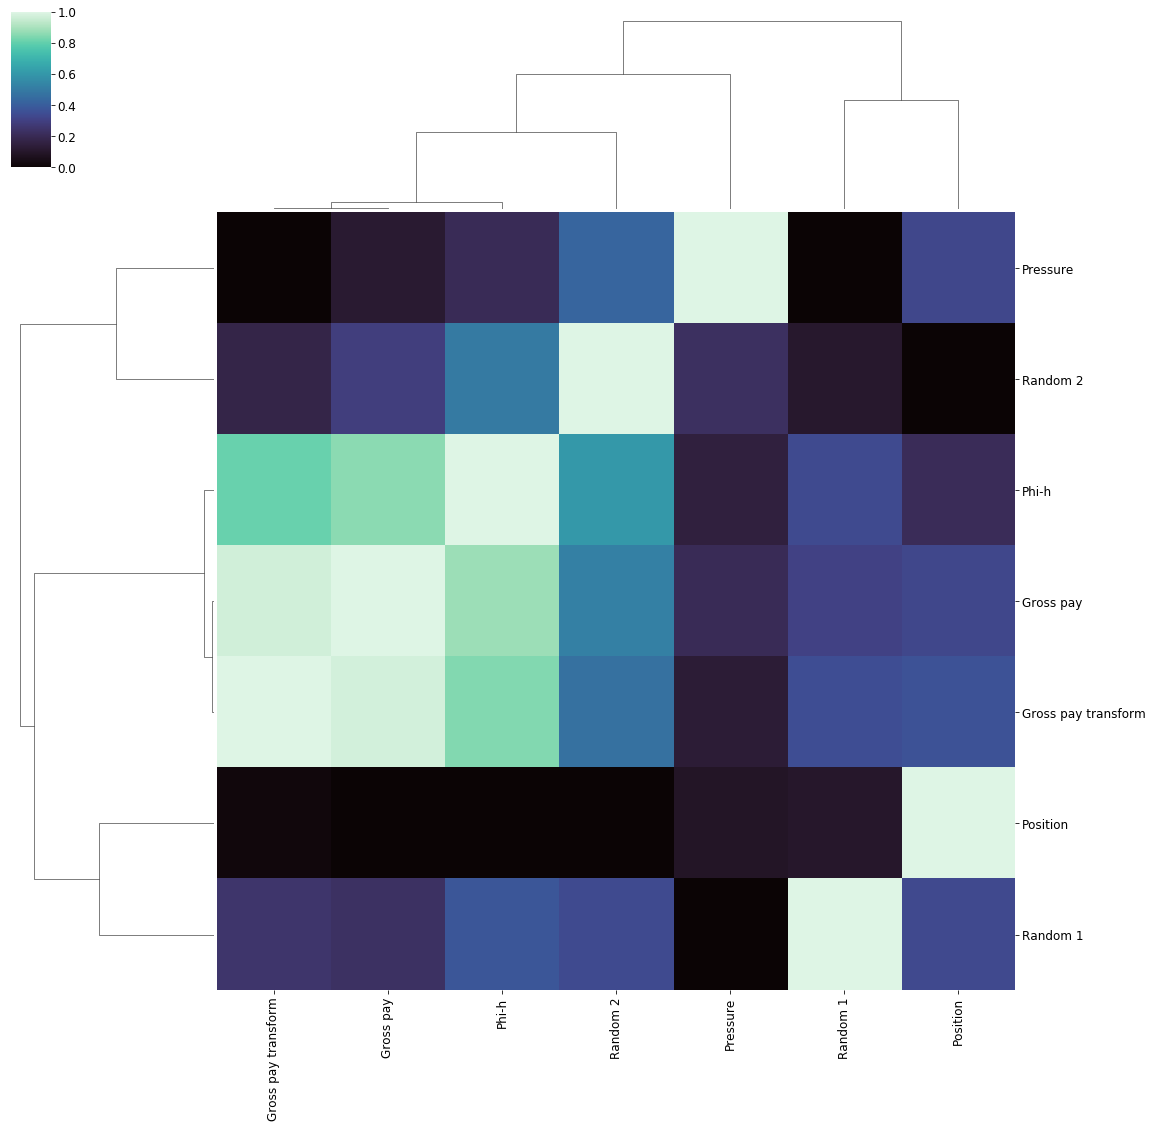

In [16]:
g = sns.clustermap(data.corr(), cmap="mako", metric='correlation', method = 'complete', robust='True',  standard_scale =1) 
fig = plt.gcf()
fig.set_size_inches(18, 18)
plt.gcf().get_axes()[1].invert_xaxis()
plt.gcf().get_axes()[2].invert_xaxis();

#### SEABORN CLUSTERING with distance correlation matrix 

In [17]:
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2)
rslt = data.apply(lambda col1: data.apply(lambda col2: distcorr(col1, col2)))
pd.options.display.float_format = '{:,.2f}'.format
rslt

,Position,Gross pay,Phi-h,Pressure,Random 1,Random 2,Gross pay transform
Position,1.00,0.28,0.32,0.22,0.32,0.54,0.23
Gross pay,0.28,1.00,0.89,0.34,0.32,0.45,0.97
Phi-h,0.32,0.89,1.00,0.27,0.35,0.54,0.83
Pressure,0.22,0.34,0.27,1.00,0.27,0.31,0.38
Random 1,0.32,0.32,0.35,0.27,1.00,0.23,0.35
Random 2,0.54,0.45,0.54,0.31,0.23,1.00,0.39
Gross pay transform,0.23,0.97,0.83,0.38,0.35,0.39,1.00


## TO DO: add variable labels

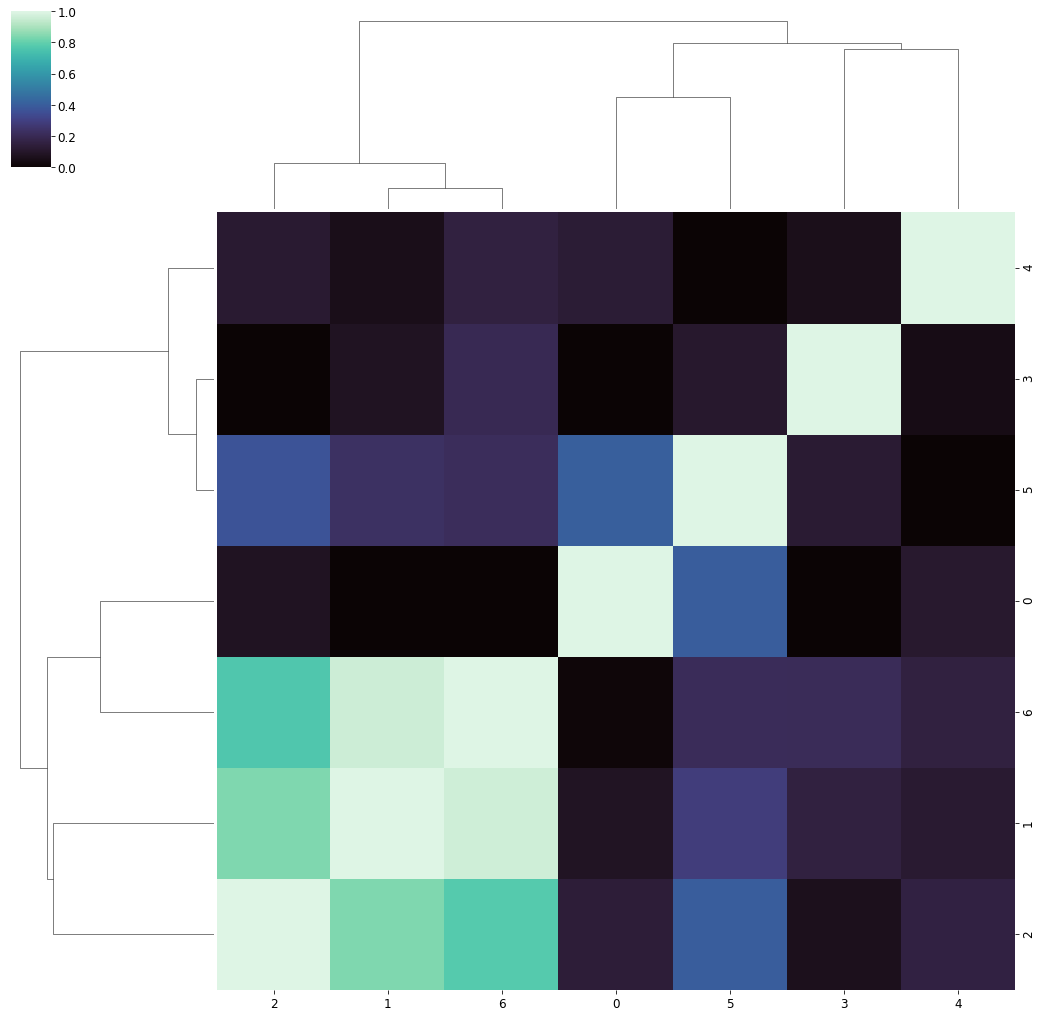

In [19]:
g = sns.clustermap(rslt.values, cmap="mako",  standard_scale =1) 
fig = plt.gcf()
fig.set_size_inches(18, 18)
plt.gcf().get_axes()[2].invert_yaxis();

## TO DO

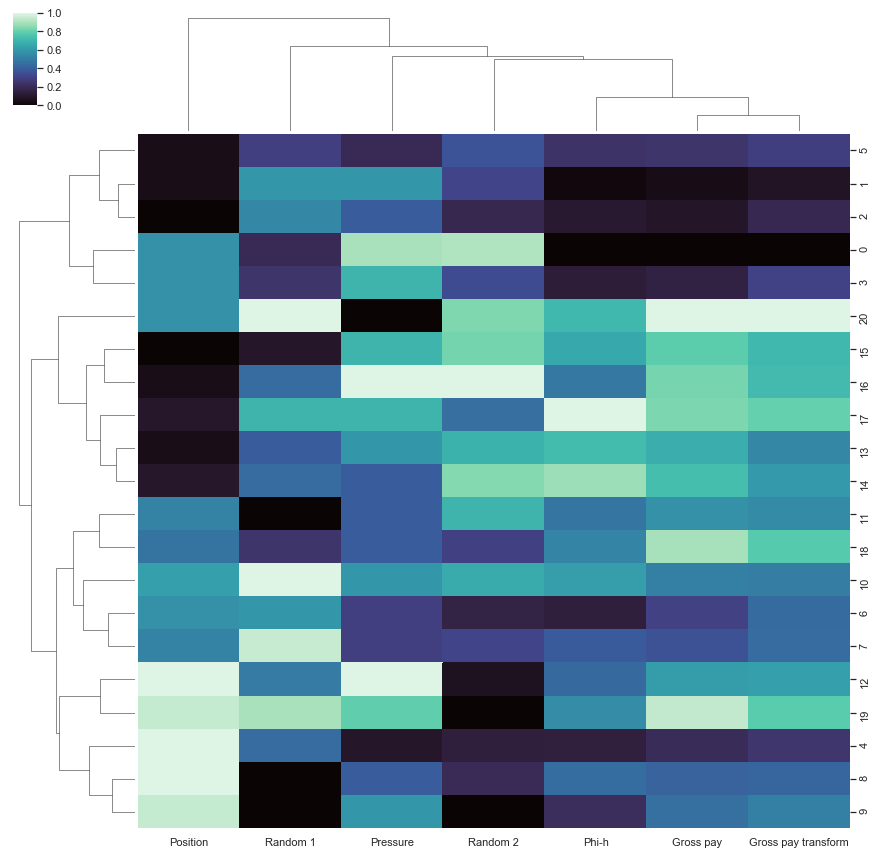

In [21]:
sns.set()
g = sns.clustermap(data, cmap="mako", figsize=(15,15), metric='euclidean', method = 'complete', robust='True',  standard_scale =1) 


#g = sns.clustermap(data, cmap="mako", figsize=(15,15), metric='euclidean', method = 'complete', robust='True',  row_cluster = 'false', standard_scale =1) 

### Try this:

https://seaborn.pydata.org/examples/structured_heatmap.html